In [1]:
%load_ext autoreload
%autoreload 2

import findspark
findspark.init()
import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.window import Window

from pyspark import SQLContext
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import lit, udf, monotonically_increasing_id, col
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
# Algos# Algorithm
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

# Others
import pandas as pd
import numpy as np
import datetime
import time

# Graphs libs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_dt

# Supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# S3 Service
# import boto3
# from io import StringIO
# # Let's use Amazon S3
# s3 = boto3.resource('s3')

# Spark context simple configuration
spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()

spark.version

'2.2.0'

In [2]:
from Helpers.technical_indicators import RSI, CCI, MACD
from Helpers.generated_features import features_from_OHLC
from Helpers.CustomTS import TrainValidationSplitSorted
from Helpers.best_model_params import *

from Helpers.udf import profit_
profit_udf = udf(profit_, IntegerType())

In [3]:
OBV_i = True
CCI_i = True
RSI_i = True
MACD_i = True

ManualSplit = True
SORT = True
CHUNKS = 10

Date_Convert = False

CV = False

DEBUG = False
RANDOM_SEED = 1

In [19]:
#Path to file with CSV

# path_to_csv = "s3://stocksets100/Orlen.csv"
path_to_csv = "./Datasets/KGHA.csv"

fresh_df = spark.read.csv(path_to_csv, header=True, inferSchema=True)

fresh_df = fresh_df.filter(fresh_df.Open != "null")

temporary_df = fresh_df.select(
    fresh_df["Date"].cast("Date"), fresh_df["Open"].cast("float"),
    fresh_df["High"].cast("float"), fresh_df["Volume"].cast("int"),
    fresh_df["Low"].cast("float"), fresh_df["Close"].cast("float"))

# id
temporary_df = temporary_df.select("*").withColumn(
    "id", monotonically_increasing_id())

featured_df = features_from_OHLC(temporary_df, spark)
featured_df.columns

['Date',
 'Open',
 'High',
 'Volume',
 'Low',
 'Close',
 'id',
 'avg_price_5',
 'avg_price_30',
 'avg_price_365',
 'ratio_avg_price_5_30',
 'ratio_avg_price_5_365',
 'ratio_avg_price_30_365',
 'avg_volume_5',
 'avg_volume_30',
 'avg_volume_365',
 'ratio_avg_volume_5_30',
 'ratio_avg_volume_5_365',
 'ratio_avg_volume_30_365',
 'std_price_5',
 'std_price_30',
 'std_price_365',
 'ratio_std_price_5_30',
 'ratio_std_price_5_365',
 'ratio_std_price_30_365',
 'std_volume_5',
 'std_volume_30',
 'std_volume_365',
 'ratio_std_volume_5_30',
 'ratio_std_volume_5_365',
 'ratio_std_volume_30_365',
 'return_1',
 'return_5',
 'return_30',
 'return_365',
 'moving_avg_5',
 'moving_avg_30',
 'moving_avg_365']

In [20]:
# Creating new column with shifted Close price by 1 day
df_daily_return = featured_df.withColumn('prev_day_price',
                                         F.lag(featured_df['Close']).over(
                                             Window.orderBy("id")))

df_daily_return = df_daily_return.filter(
    df_daily_return.prev_day_price.isNotNull())

# Profit label calculation
# 1 if stock risen up, 0 is it went down
df_profit = df_daily_return.withColumn(
    'Profit', profit_udf(df_daily_return.Close,
                         df_daily_return.prev_day_price))

df_shifted_profit = df_profit.withColumn(
    'Profit',
    F.lag(df_profit['Profit'], count=-1).over(Window.orderBy("Date")))

final_df = df_shifted_profit.filter(df_shifted_profit.Profit.isNotNull())

# Removing redudant columns
final_df = final_df.drop("Daily return")
final_df = final_df.drop("prev_day_price")

if DEBUG:
    final_df.show(2)
    
converted_df = final_df

In [21]:
#Columns without Date
# converted_df = converted_df.select(
#     [col(c).cast('float') for c in converted_df.columns if c. not in {'Date'}])

# Date column!
df_date = converted_df.select(converted_df.Date)
df_date = df_date.select("*").withColumn("id", monotonically_increasing_id())

#Convert date to splitted format
if Date_Convert:
    split_col = pyspark.sql.functions.split(converted_df['Date'], '-')
    converted_df = converted_df.withColumn('Year',
                                           split_col.getItem(0).cast('int'))
    converted_df = converted_df.withColumn('Month',
                                           split_col.getItem(1).cast('int'))
    converted_df = converted_df.withColumn('Day',
                                           split_col.getItem(2).cast('int'))
    if DEBUG:
        converted_df.show()

converted_df = converted_df.drop("Date")

In [22]:
if MACD_i:
    converted_df = MACD(converted_df, spark)
    converted_df = converted_df.select(
        [col(c).cast('float') for c in converted_df.columns])
    if DEBUG:
        converted_df.show()

if CCI_i:
    converted_df = CCI(converted_df, 14, spark)
    converted_df = converted_df.select(
        [col(c).cast('float') for c in converted_df.columns])
    converted_df = converted_df.filter(converted_df.CCI != "NaN")
    if DEBUG:
        converted_df.show()

if OBV_i:
    temp_df = converted_df.toPandas()
    df_obv = spark.createDataFrame(
        temp_df.assign(OBV=(temp_df.Volume * (
            ~temp_df.Close.diff().le(0) * 2 - 1)).cumsum()))
    converted_df = df_obv.select(
        [col(c).cast('float') for c in df_obv.columns])
    if DEBUG:
        converted_df.show()

if RSI_i:
    converted_df = RSI(converted_df, 3, 'EWMA', spark)
    converted_df = converted_df.filter(converted_df.RSI != "NaN")
    if DEBUG:
        converted_df.show()

In [8]:
converted_df = converted_df.sort(converted_df.id.asc())

if DEBUG:
    print(converted_df.count())

# Manual split for training and validating data
if ManualSplit:
    dfp = converted_df.toPandas()
    dfp = np.array_split(dfp, CHUNKS)
    train = spark.createDataFrame(data=dfp[0].round(3))
    for i in range(1, len(dfp) - 1):
        p = spark.createDataFrame(data=dfp[i].round(3))
        train = train.union(p)
    test = spark.createDataFrame(data=dfp[-1].round(3))
else:
    train, test = converted_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)

print("We have %d training examples and %d test examples." % (train.count(),
                                                              test.count()))
if SORT:
    test = test.sort(test.id.asc())
    train = train.sort(train.id.asc())

if not DEBUG:
    train.show()
    test.show()

We have 906 training examples and 100 test examples.
+------+------+------+------+------+-----+-----------+------------+-------------+--------------------+---------------------+----------------------+------------+-------------+--------------+---------------------+----------------------+-----------------------+-----------+------------+-------------+--------------------+---------------------+----------------------+------------+-------------+--------------+---------------------+----------------------+-----------------------+--------+--------+---------+----------+------------+-------------+--------------+------+------+--------+------+------+
|  Open|  High|Volume|   Low| Close|   id|avg_price_5|avg_price_30|avg_price_365|ratio_avg_price_5_30|ratio_avg_price_5_365|ratio_avg_price_30_365|avg_volume_5|avg_volume_30|avg_volume_365|ratio_avg_volume_5_30|ratio_avg_volume_5_365|ratio_avg_volume_30_365|std_price_5|std_price_30|std_price_365|ratio_std_price_5_30|ratio_std_price_5_365|ratio_std_pric

In [9]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
featuresCols = converted_df.columns
featuresCols.remove('Profit')
featuresCols.remove('id')

print(featuresCols)

# Vector Assembler
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
# Used for assembling features into a vector.
# We will pass all the columns that we are going to use for the prediction to the VectorAssembler and
# it will create a new vector column.
vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="features")

['Open', 'High', 'Volume', 'Low', 'Close', 'avg_price_5', 'avg_price_30', 'avg_price_365', 'ratio_avg_price_5_30', 'ratio_avg_price_5_365', 'ratio_avg_price_30_365', 'avg_volume_5', 'avg_volume_30', 'avg_volume_365', 'ratio_avg_volume_5_30', 'ratio_avg_volume_5_365', 'ratio_avg_volume_30_365', 'std_price_5', 'std_price_30', 'std_price_365', 'ratio_std_price_5_30', 'ratio_std_price_5_365', 'ratio_std_price_30_365', 'std_volume_5', 'std_volume_30', 'std_volume_365', 'ratio_std_volume_5_30', 'ratio_std_volume_5_365', 'ratio_std_volume_30_365', 'return_1', 'return_5', 'return_30', 'return_365', 'moving_avg_5', 'moving_avg_30', 'moving_avg_365', 'MACD', 'CCI', 'OBV', 'RSI']


In [10]:
# Patrameters grid testing
# rt = DecisionTreeClassifier(
#     labelCol='Profit', featuresCol="features", minInfoGain=0.01,  maxBins=200)

rt = RandomForestClassifier(
    labelCol='Profit', featuresCol="features", numTrees=25, maxBins=300)

max_Depth_Range = list(range(5, 15))
min_InstancesPerNode = list(range(5, 15))

paramGrid = ParamGridBuilder() \
    .addGrid(rt.maxDepth, max_Depth_Range) \
    .addGrid(rt.maxMemoryInMB, [1000] ).build()

# We define an evaluation metric. This tells Validator how well we are doing by comparing the true
# labels with predictions.

multi = MulticlassClassificationEvaluator(
    labelCol=rt.getLabelCol(),
    metricName='accuracy',
    predictionCol=rt.getPredictionCol())

evaluator_rt = BinaryClassificationEvaluator(
    labelCol=rt.getLabelCol(),
    metricName='areaUnderROC',
    rawPredictionCol=rt.getRawPredictionCol())

evaluator_rt_PR = BinaryClassificationEvaluator(
    labelCol=rt.getLabelCol(),
    metricName='areaUnderPR',
    rawPredictionCol=rt.getRawPredictionCol())

# Declare the CrossValidator, which runs model tuning for us.
if CV:
    val = CrossValidator(
        estimator=rt,
        evaluator=multi,
        estimatorParamMaps=paramGrid,
        numFolds=2)
else:
    val = TrainValidationSplitSorted(
        chunks = CHUNKS,
        spark = spark,
        estimator=rt,
        estimatorParamMaps=paramGrid,
        evaluator=multi)

In [11]:
# Creating Final pipeline object
pipeline_rt = Pipeline(stages=[vectorAssembler_rt, val])

# FITTING!
pipelineModel_rt = pipeline_rt.fit(train)

# Getting the Best Model
best_classifier = pipelineModel_rt.stages[-1].bestModel

In [12]:
# Feature importance
print('Features importances' + str(best_classifier.featureImportances))
final_features = best_classifier.featureImportances
   
for feature, importance in zip(featuresCols, final_features):
    print("{} - {}".format(feature, round(importance, 3)))

Features importances(40,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39],[0.034906157736,0.0327874254677,0.075782918722,0.0194497574859,0.0166626010054,0.0164535500065,0.0169819944854,0.0235203157267,0.0406692814971,0.032068758483,0.0331176114672,0.0139118868023,0.0175274021224,0.0181808667634,0.0145593691314,0.0138301233459,0.021447693762,0.0217812313176,0.0309186646408,0.0219165796181,0.0379595321153,0.0329823748361,0.0312950642656,0.0144326483301,0.0167199294277,0.017378618312,0.0244632900622,0.010081864053,0.012809298652,0.0305473059372,0.0316518385261,0.0336891522337,0.0238697345427,0.0261117542315,0.0160854849659,0.00368807016463,0.0269032292262,0.0408255638904,0.0119187986565,0.0401122579841])
Open - 0.035
High - 0.033
Volume - 0.076
Low - 0.019
Close - 0.017
avg_price_5 - 0.016
avg_price_30 - 0.017
avg_price_365 - 0.024
ratio_avg_price_5_30 - 0.041
ratio_avg_price_5_365 - 0.032
ratio_avg_price_30_365 - 0.033
avg_vol

In [13]:
# Model Parameters!
# Max depth
print("Maximal depth is " + str(best_classifier.getMaxDepth()))
max_depth = best_classifier.getMaxDepth()

# Min instances
print("Minimal instances per node is " + str(
    best_classifier.getMinInstancesPerNode()))
min_instancesPerNode = best_classifier.getMinInstancesPerNode()

# Making Predictions!
predictions_rt = pipelineModel_rt.transform(test)

Maximal depth is 11
Minimal instances per node is 1


In [14]:
# Accuracy
accuracy = multi.evaluate(predictions_rt)
print("Accuracy is equal to {}%".format(round(accuracy, 3)))

Accuracy is equal to 0.61%


In [15]:
# Calculating metrics
AreaUnderROC = evaluator_rt.evaluate(predictions_rt)
print("AreaUnderROC on our test set: %g" % AreaUnderROC)

# Calculating metrics
AreaUnderPR = evaluator_rt_PR.evaluate(predictions_rt)
print("AreaUnderPR on our test set: %g" % AreaUnderPR)

#evaluate results
testCount = predictions_rt.count()

FP = predictions_rt.where("prediction = 1 AND Profit = 0").count()
FN = predictions_rt.where("prediction = 0 AND Profit = 1").count()
TP = predictions_rt.where("prediction = 1 AND Profit = 1").count()
TN = predictions_rt.where("prediction = 0 AND Profit = 0").count()

print("Count | FP | FN | TP | TN")
print(
    str(testCount) + " | " + str(FP) + " | " + str(FN) + " | " + str(TP) +
    " | " + str(TN))

# predictions_rt.show()

AreaUnderROC on our test set: 0.60064
AreaUnderPR on our test set: 0.604227
Count | FP | FN | TP | TN
100 | 12 | 27 | 22 | 39


DataFrame[prediction: double, Profit: double]


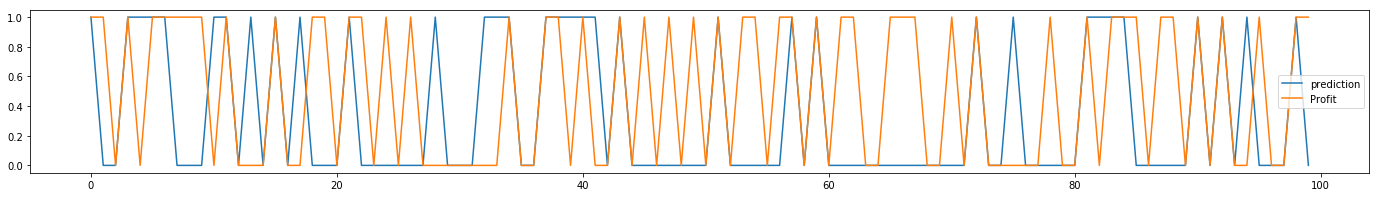

In [16]:
test = predictions_rt.toPandas()
# csv_buffer = StringIO()
# test.to_csv(csv_buffer)

# s3_resource = boto3.resource('s3')

# s3_resource.Object('logs102', 'DT_Final.csv').put(Body=csv_buffer.getvalue())

if DEBUG != True:
    df_to_plot_rt = predictions_rt.select('prediction', 'Profit')
    print(df_to_plot_rt)
    df_to_plot_rt = df_to_plot_rt.toPandas()
    plt_dt.figure(figsize=(24, 3))
    plt_dt.plot(df_to_plot_rt)
    plt_dt.legend(df_to_plot_rt.columns)
    plt_dt.show()
    

In [23]:
# final_model = pipelineModel_rt
from random import *

for i in range(30):
    new_train, new_test = converted_df.randomSplit([0.1, 0.9], seed=i + 1)
    new_test = new_test.sort(new_test.id.asc())

    predictions = pipelineModel_rt.transform(new_test)

    # Calculating metrics
    AreaUnderROC = evaluator_rt.evaluate(predictions)
    print("AreaUnderROC on our test set: %g" % AreaUnderROC)

    # Calculating metrics
    AreaUnderPR = evaluator_rt_PR.evaluate(predictions)
    print("AreaUnderPR on our test set: %g" % AreaUnderPR)

    # Accuracy
    accuracy = multi.evaluate(predictions)
    print("Accuracy is equal to {}%".format(round(accuracy, 3)))

    #evaluate results
    testCount = predictions.count()

    FP = predictions.where("prediction = 1 AND Profit = 0").count()
    FN = predictions.where("prediction = 0 AND Profit = 1").count()   
    TP = predictions.where("prediction = 1 AND Profit = 1").count() 
    TN = predictions.where("prediction = 0 AND Profit = 0").count()

    print("Count | FP | FN | TP | TN")
    print(
        str(testCount) + " | " + str(FP) + " | " + str(FN) + " | " + str(TP) +
        " | " + str(TN))

    print("####################################################")

AreaUnderROC on our test set: 0.551781
AreaUnderPR on our test set: 0.498889
Accuracy is equal to 0.537%
Count | FP | FN | TP | TN
1179 | 211 | 335 | 207 | 426
####################################################
AreaUnderROC on our test set: 0.561938
AreaUnderPR on our test set: 0.510589
Accuracy is equal to 0.545%
Count | FP | FN | TP | TN
1181 | 202 | 335 | 208 | 436
####################################################
AreaUnderROC on our test set: 0.561397
AreaUnderPR on our test set: 0.498118
Accuracy is equal to 0.542%
Count | FP | FN | TP | TN
1184 | 210 | 332 | 206 | 436
####################################################
AreaUnderROC on our test set: 0.560507
AreaUnderPR on our test set: 0.507841
Accuracy is equal to 0.543%
Count | FP | FN | TP | TN
1186 | 210 | 332 | 209 | 435
####################################################
AreaUnderROC on our test set: 0.55747
AreaUnderPR on our test set: 0.503764
Accuracy is equal to 0.539%
Count | FP | FN | TP | TN
1188 | 210 | 338 |